# Obtain GOES16/18 SW/SST data for all of 2023

> [Beginner's Guide](https://storage.googleapis.com/gcs-public-datasets/GOES-R%20beginners%20guide%20-%20EN.pdf)

## Process sst

In [1]:
import gcsfs
import xarray as xr
import json
import fsspec
import gcsfs
import numpy as np
import cmocean as cm
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

#thanks to Charles Stern for ingesting 2023 sst, he saved it to the following path
sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/goes-sst-2023/goes.zarr'))

In [2]:
sst_url = 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc'
fp = fsspec.open(sst_url)
single_ds = xr.open_dataset(fp.open(), engine="h5netcdf")

In [3]:
projection = single_ds.goes_imager_projection

In [4]:
projection

<xarray.DataArray 'goes_imager_projection' ()> Size: 4B
[1 values with dtype=int32]
Coordinates:
    t                                datetime64[ns] 8B ...
    y_image                          float32 4B ...
    x_image                          float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
    day_solar_zenith_angle           float32 4B ...
    night_solar_zenith_angle         float32 4B ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [5]:
sst['goes_imager_projection'] = projection

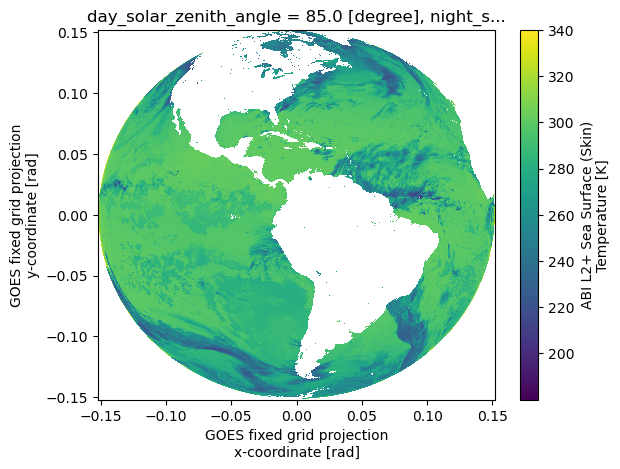

In [53]:
sst.SST[100].plot()

In [6]:
sst_cut = sst.isel(y=slice(None, 2712))

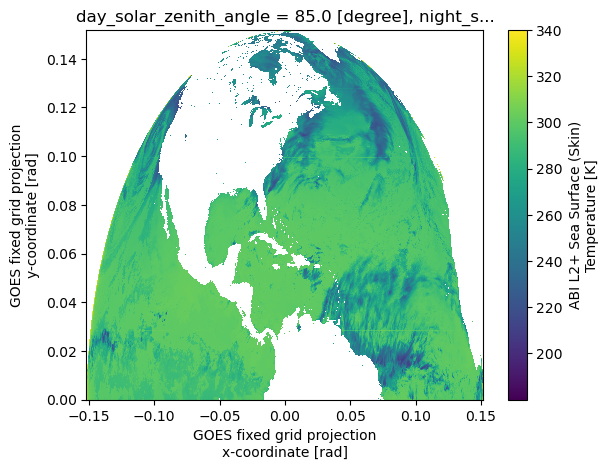

In [7]:
sst_cut.SST[100].plot()

In [8]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2

    #r_s = (-b - root_thing)/(2*a)
    r_s = (-b - (-1*np.sqrt(-1*(b**2 - 4*a*c))))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [9]:
t = calc_latlon(sst_cut)

/tmp/ipykernel_2998/3422569089.py:22: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - (-1*np.sqrt(-1*(b**2 - 4*a*c))))/(2*a)


In [12]:
t

<xarray.Dataset> Size: 1TB
Dimensions:                          (t: 8743, y: 2712, x: 5424)
Coordinates:
    day_solar_zenith_angle           float32 4B ...
    night_solar_zenith_angle         float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * t                                (t) datetime64[ns] 70kB 2023-01-01T00:30...
  * x                                (x) float64 43kB -0.1518 -0.1518 ... 0.1518
    x_image                          float32 4B ...
  * y                                (y) float64 22kB 0.1518 ... 2.799e-05
    y_image                          float32 4B ...
    lat                              (y, x) float64 118MB 40.56 40.57 ... nan
    lon                              (y, x) float64 118MB -15.69 -15.69 ... nan
Data variables:
    SST                              (t, y, x) float64 1TB dask.array<chunksize=(1, 2712, 5424), meta=np.ndarray>
    goes_imager_projection           int32 4B ...
Attributes: (12/27)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    _FillValue:                -999.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    grid_mapping:              goes_imager_projection
    ...                        ...
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The ABI Sea Surface Temperature (SST) is calcu...
    title:                     ABI L2 Sea Surface (Skin) Temperature
    units:                     K

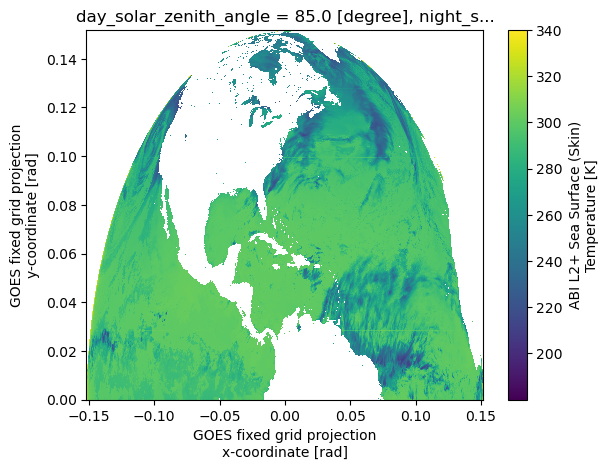

In [11]:
t.SST[100].plot()

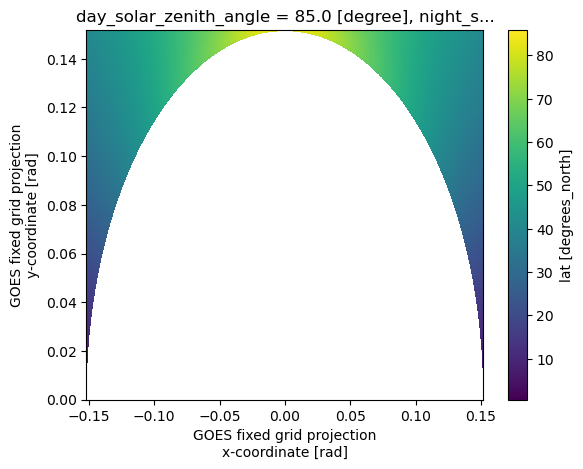

In [70]:
t.lat.plot()

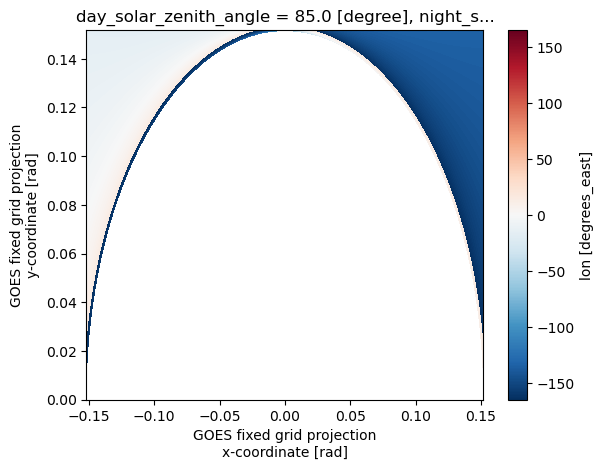

In [71]:
t.lon.plot()

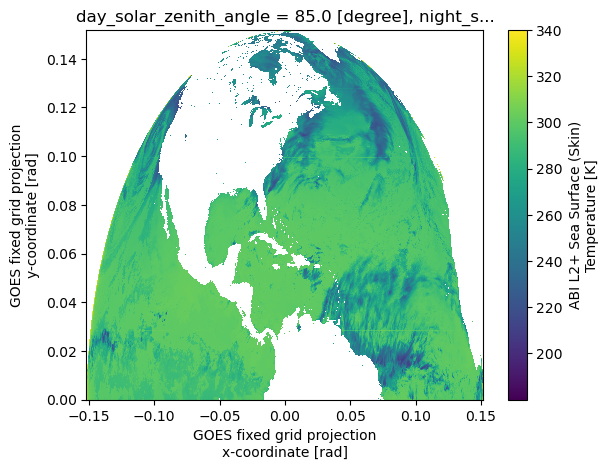

In [64]:
t.SST[100].plot()

In [50]:
p = [-1, 0, 4, -5, 77]
for i in p:
    if i < 0:
        print('it works')

it works
it works


In [44]:
ds = calc_latlon(sst)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [41]:
ds

<xarray.Dataset> Size: 2TB
Dimensions:                          (t: 8743, y: 5424, x: 5424)
Coordinates:
    day_solar_zenith_angle           float32 4B ...
    night_solar_zenith_angle         float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * t                                (t) datetime64[ns] 70kB 2023-01-01T00:30...
  * x                                (x) float64 43kB -0.1518 -0.1518 ... 0.1518
    x_image                          float32 4B ...
  * y                                (y) float64 43kB 0.1518 0.1518 ... -0.1518
    y_image                          float32 4B ...
    lat                              (y, x) float64 235MB 28.52 28.53 ... -28.52
    lon                              (y, x) float64 235MB -108.1 ... -41.91
Data variables:
    SST                              (t, y, x) float64 2TB dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    goes_imager_projection           int32 4B ...
Attributes: (12/27)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    _FillValue:                -999.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    grid_mapping:              goes_imager_projection
    ...                        ...
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The ABI Sea Surface Temperature (SST) is calcu...
    title:                     ABI L2 Sea Surface (Skin) Temperature
    units:                     K

In [20]:
ds.SST

<xarray.DataArray 'SST' (t: 8743, y: 5424, x: 5424)> Size: 2TB
dask.array<open_dataset-SST, shape=(8743, 5424, 5424), dtype=float64, chunksize=(1, 5424, 5424), chunktype=numpy.ndarray>
Coordinates:
    day_solar_zenith_angle           float32 4B ...
    night_solar_zenith_angle         float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * t                                (t) datetime64[ns] 70kB 2023-01-01T00:30...
  * x                                (x) float64 43kB -0.1518 -0.1518 ... 0.1518
    x_image                          float32 4B ...
  * y                                (y) float64 43kB 0.1518 0.1518 ... -0.1518
    y_image                          float32 4B ...
    lat                              (y, x) float64 235MB 28.52 28.53 ... -28.52
    lon                              (y, x) float64 235MB -108.1 ... -41.91
Attributes:
    algorithm_type:       regression
    ancillary_variables:  DQF
    cell_methods:         retrieval_local_zenith_angle: point (good or degrad...
    grid_mapping:         goes_imager_projection
    long_name:            ABI L2+ Sea Surface (Skin) Temperature
    resolution:           y: 0.000056 rad x: 0.000056 rad
    standard_name:        sea_surface_skin_temperature
    units:                K
    valid_range:          [0, 65530]

In [38]:
ds['lon'] = ds.lon[0,:]
ds['lat'] = ds.lat[:,0]

In [39]:
ds

<xarray.Dataset> Size: 2TB
Dimensions:                          (t: 8743, y: 5424, x: 5424)
Coordinates:
    day_solar_zenith_angle           float32 4B ...
    night_solar_zenith_angle         float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * t                                (t) datetime64[ns] 70kB 2023-01-01T00:30...
  * x                                (x) float64 43kB -0.1518 -0.1518 ... 0.1518
    x_image                          float32 4B ...
  * y                                (y) float64 43kB 0.1518 0.1518 ... -0.1518
    y_image                          float32 4B ...
    lat                              (y) float64 43kB 28.52 28.52 ... -28.52
    lon                              (x) float64 43kB -108.1 -108.1 ... -41.91
Data variables:
    SST                              (t, y, x) float64 2TB dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    goes_imager_projection           int32 4B ...
Attributes: (12/27)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    _FillValue:                -999.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    grid_mapping:              goes_imager_projection
    ...                        ...
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The ABI Sea Surface Temperature (SST) is calcu...
    title:                     ABI L2 Sea Surface (Skin) Temperature
    units:                     K

In [34]:
ds_reassign = ds.swap_dims({'x':'lon', 'y':'lat'})

ValueError: replacement dimension 'lat' is not a 1D variable along the old dimension 'y'

In [ ]:
ds.SST[100].plot()

In [77]:
lon = np.rad2deg((sst.x*10))
lat = np.rad2deg((sst.y*10))

In [78]:
ds = sst.assign_coords({'lat':lat, 'lon':lon}).swap_dims({'x':'lon', 'y':'lat'})

In [79]:
ds

<xarray.Dataset> Size: 2TB
Dimensions:                          (t: 8743, lat: 5424, lon: 5424)
Coordinates:
    day_solar_zenith_angle           float32 4B 85.0
    night_solar_zenith_angle         float32 4B 95.0
    quantitative_local_zenith_angle  float32 4B 67.0
    retrieval_local_zenith_angle     float32 4B 90.0
    retrieval_solar_zenith_angle     float32 4B 180.0
  * t                                (t) datetime64[ns] 70kB 2023-01-01T00:30...
    x                                (lon) float64 43kB -0.1518 ... 0.1518
    x_image                          float32 4B 0.0
    y                                (lat) float64 43kB 0.1518 ... -0.1518
    y_image                          float32 4B 0.0
  * lat                              (lat) float64 43kB 87.0 86.97 ... -87.0
  * lon                              (lon) float64 43kB -87.0 -86.97 ... 87.0
Data variables:
    SST                              (t, lat, lon) float64 2TB dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    _FillValue:                -999.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    grid_mapping:              goes_imager_projection
    ...                        ...
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The ABI Sea Surface Temperature (SST) is calcu...
    title:                     ABI L2 Sea Surface (Skin) Temperature
    units:                     K

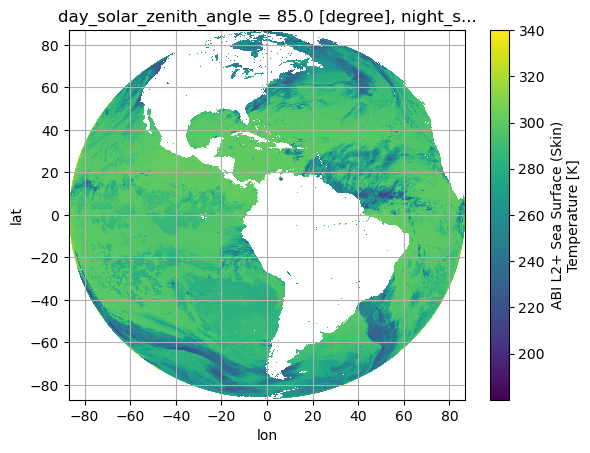

In [63]:
ds.SST[100].plot()
plt.grid()

In [90]:
g_gulf = dict(lon=slice(-35, -15), lat=slice(45,30))
ggom = ds.sel(**g_gulf).sortby('lat')

In [91]:
gom.dims

FrozenMappingWarningOnValuesAccess({'t': 8743, 'lat': 280, 'lon': 468})

In [92]:
ggom.dims

FrozenMappingWarningOnValuesAccess({'t': 8743, 'lat': 467, 'lon': 624})

In [50]:
gulf = dict(lon=slice(-100, -72), lat=slice(31,22))
gom = ds.sel(**gulf).sortby('lat')

In [51]:
gom

<xarray.Dataset> Size: 9GB
Dimensions:                          (t: 8743, lat: 280, lon: 468)
Coordinates:
    day_solar_zenith_angle           float32 4B 85.0
    night_solar_zenith_angle         float32 4B 95.0
    quantitative_local_zenith_angle  float32 4B 67.0
    retrieval_local_zenith_angle     float32 4B 90.0
    retrieval_solar_zenith_angle     float32 4B 180.0
  * t                                (t) datetime64[ns] 70kB 2023-01-01T00:30...
    x                                (lon) float64 4kB -0.1518 ... -0.1257
    x_image                          float32 4B 0.0
    y                                (lat) float64 2kB 0.03844 ... 0.05407
    y_image                          float32 4B 0.0
  * lat                              (lat) float64 2kB 22.03 22.06 ... 30.98
  * lon                              (lon) float64 4kB -87.0 -86.97 ... -72.02
Data variables:
    SST                              (t, lat, lon) float64 9GB dask.array<chunksize=(1, 280, 468), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    _FillValue:                -999.0
    cdm_data_type:             Image
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    grid_mapping:              goes_imager_projection
    ...                        ...
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The ABI Sea Surface Temperature (SST) is calcu...
    title:                     ABI L2 Sea Surface (Skin) Temperature
    units:                     K

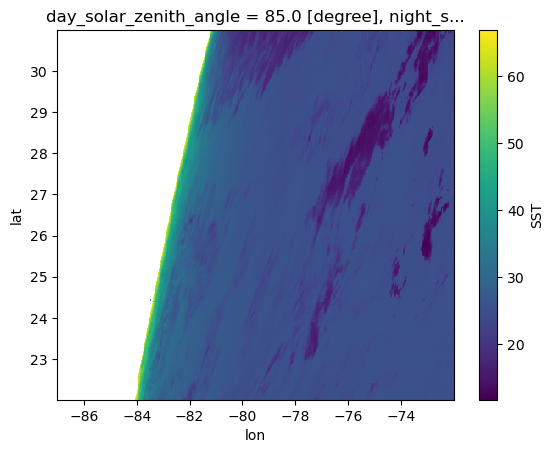

In [42]:
gom.SST[100].plot()

In [55]:
mean_sst = (gom.SST-273.15).mean('t')

In [60]:
mean_sst.load()

<xarray.DataArray 'SST' (lat: 280, lon: 468)> Size: 1MB
array([[        nan,         nan,         nan, ..., 14.81207976,
        14.79650278, 14.76517812],
       [        nan,         nan,         nan, ..., 14.82769055,
        14.82716227, 14.78069867],
       [        nan,         nan,         nan, ..., 14.83080153,
        14.845446  , 14.81087236],
       ...,
       [        nan,         nan,         nan, ..., 11.70496935,
        11.72235518, 11.71668644],
       [        nan,         nan,         nan, ..., 11.68670447,
        11.70284979, 11.71579956],
       [        nan,         nan,         nan, ..., 11.66528539,
        11.67235386, 11.69579613]])
Coordinates:
    day_solar_zenith_angle           float32 4B 85.0
    night_solar_zenith_angle         float32 4B 95.0
    quantitative_local_zenith_angle  float32 4B 67.0
    retrieval_local_zenith_angle     float32 4B 90.0
    retrieval_solar_zenith_angle     float32 4B 180.0
    x                                (lon) float64 4kB -0.1518 ... -0.1257
    x_image                          float32 4B 0.0
    y                                (lat) float64 2kB 0.03844 ... 0.05407
    y_image                          float32 4B 0.0
  * lat                              (lat) float64 2kB 22.03 22.06 ... 30.98
  * lon                              (lon) float64 4kB -87.0 -86.97 ... -72.02

In [57]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(15)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

Task exception was never retrieved
future: <Task finished name='Task-4240' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Mean SST for 2023')

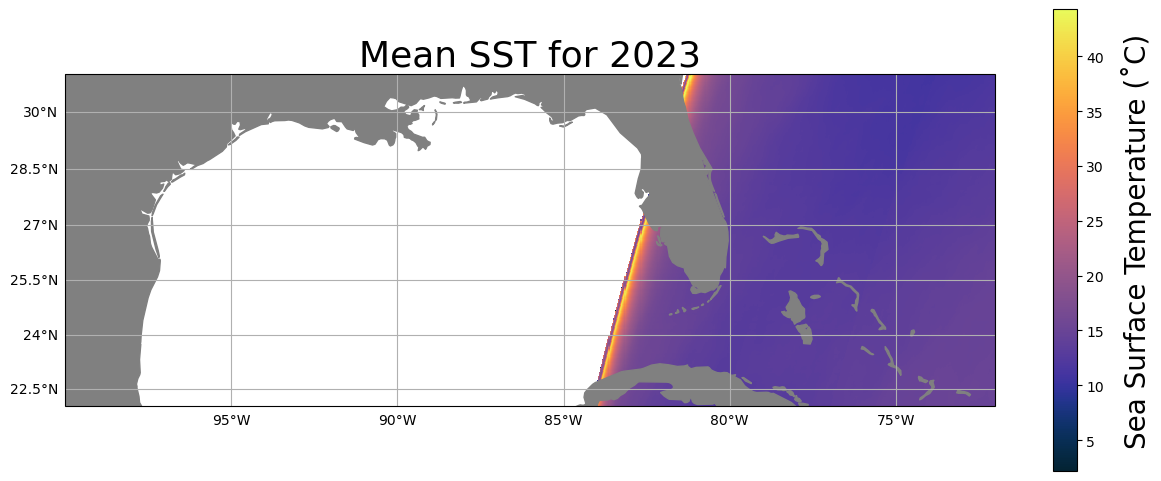

In [62]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-100, -72, 22, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
#ax.contour(lon, lat, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(gom.lon, gom.lat, mean_sst, transform=ccrs.PlateCarree(), cmap=cm.cm.thermal,)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Sea Surface Temperature (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Mean SST for 2023', fontsize=26)
#plt.savefig('bot-temp-ecco-1kmisobath.pdf', transparent=True);

In [7]:
import xarray as xr
import fsspec
import gcsfs
import numpy as np
import matplotlib.pyplot as plt

In [8]:
url = "https://storage.googleapis.com/gcp-public-data-goes-18/ABI-L2-DSRF/2023/227/16/OR_ABI-L2-DSRF-M6_G18_s20232271600219_e20232271609527_c20232271623259.nc"
sst_url = 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc'
sst_18 = 'https://storage.googleapis.com/gcp-public-data-goes-18/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G18_s20230010000203_e20230010059511_c20230010105438.nc'
fp = fsspec.open(sst_url)
ds = xr.open_dataset(fp.open(), engine="h5netcdf")

In [9]:
ds

<xarray.Dataset> Size: 235MB
Dimensions:                                                 (y: 5424, x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             SST_night_only_emissive_band: 1,
                                                             SST_day_night_emissive_bands: 4)
Coordinates: (12/14)
    t                                                       datetime64[ns] 8B ...
  * y                                                       (y) float32 22kB ...
  * x                                                       (x) float32 22kB ...
    y_image                                                 float32 4B ...
    x_image                                                 float32 4B ...
    retrieval_local_zenith_angle                            float32 4B ...
    ...                                                      ...
    day_solar_zenith_angle                                  float32 4B ...
    night_solar_zenith_angle                                float32 4B ...
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 4B ...
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 16B ...
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 1B ...
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 4B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                SST_night_only_emissive_band,
                                SST_day_night_emissive_bands
Data variables: (12/42)
    SST                                                     (y, x) float32 118MB ...
    DQF                                                     (y, x) float32 118MB ...
    time_bounds                                             (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                                  int32 4B ...
    y_image_bounds                                          (number_of_image_bounds) float32 8B ...
    x_image_bounds                                          (number_of_image_bounds) float32 8B ...
    ...                                                      ...
    retrieval_solar_zenith_angle_bounds                     (number_of_SZA_bounds) float32 8B ...
    day_solar_zenith_angle_bounds                           (number_of_SZA_bounds) float32 8B ...
    night_solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 8B ...
    twilight_solar_zenith_angle_bounds                      (number_of_SZA_bounds) float32 8B ...
    percent_uncorrectable_GRB_errors                        float32 4B ...
    percent_uncorrectable_L0_errors                         float32 4B ...
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    long_name:                 standard deviation of the difference of the ob...
    _FillValue:                -999.0
    units:                     K
    grid_mapping:              goes_imager_projection
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    id:                        7c07908e-b67a-466d-965e-2a5874012d46

In [10]:
projection = ds.goes_imager_projection

In [69]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [72]:
proj = calc_latlon(ds)

/tmp/ipykernel_434/1456945755.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


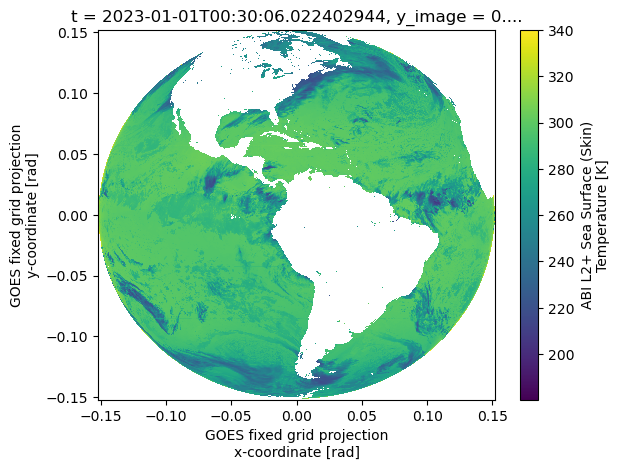

In [74]:
proj.SST.plot()

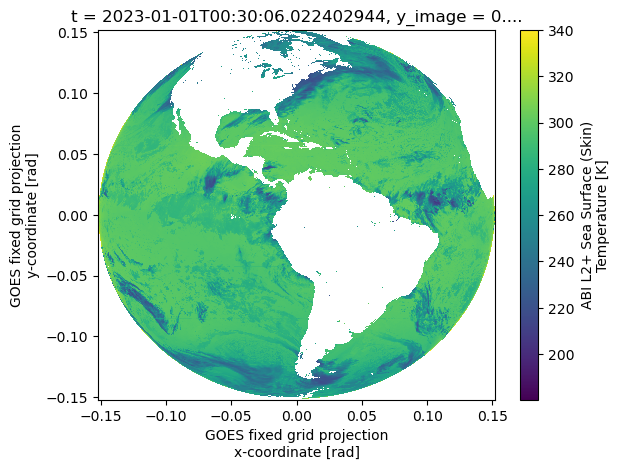

In [65]:
ds.SST.plot()

In [9]:
ds.x

<xarray.DataArray 'x' (x: 5424)> Size: 22kB
array([-0.151844, -0.151788, -0.151732, ...,  0.151732,  0.151788,  0.151844],
      dtype=float32)
Coordinates:
    t                                datetime64[ns] 8B ...
  * x                                (x) float32 22kB -0.1518 -0.1518 ... 0.1518
    y_image                          float32 4B ...
    x_image                          float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
    day_solar_zenith_angle           float32 4B ...
    night_solar_zenith_angle         float32 4B ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

In [ ]:
#9:25 ran cell 
ds = xr.open_mfdataset('OR_ABI*.nc', decode_times=False, concat_dim='t', combine='nested')

In [ ]:
ds

In [23]:
ds.t

<xarray.DataArray 't' (t: 17)> Size: 136B
array([ 7.263614e+08,  7.336190e+08, -9.990000e+02, -9.990000e+02,
       -9.990000e+02, -9.990000e+02, -9.990000e+02, -9.990000e+02,
        7.420862e+08,  7.432958e+08,  7.445054e+08,  7.457150e+08,
       -9.990000e+02, -9.990000e+02,  7.493435e+08,  7.545275e+08,
       -9.990000e+02])
Coordinates:
  * t                                (t) float64 136B 7.264e+08 ... -999.0
    y_image                          float32 4B 0.0
    x_image                          float32 4B 0.0
    retrieval_local_zenith_angle     float32 4B 90.0
    quantitative_local_zenith_angle  float32 4B 67.0
    retrieval_solar_zenith_angle     float32 4B 180.0
    day_solar_zenith_angle           float32 4B 85.0
    night_solar_zenith_angle         float32 4B 95.0
Attributes:
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time
    axis:           T
    bounds:         time_bounds
    units:          seconds since 2000-01-01T12:00:00
    calendar:       proleptic_gregorian

In [84]:
import gcsfs

gcs = gcsfs.GCSFileSystem()

#file_list = gcs.glob("gcp-public-data-goes-16/ABI-L2-DSRF/2023/*/*/*.nc")
file_list_nohttp = gcs.glob('gs://gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc')
file_list = ["https://storage.googleapis.com/" + uri for uri in file_list_nohttp]
ds = xr.open_dataset(fsspec.open(file_list).open(), engine='h5netcdf')

AttributeError: 'list' object has no attribute 'startswith'

In [83]:
file_list

['https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc']

In [24]:
url = "https://storage.googleapis.com/gcp-public-data-goes-18/ABI-L2-DSRF/2023/227/16/OR_ABI-L2-DSRF-M6_G18_s20232271600219_e20232271609527_c20232271623259.nc"
sst_url = 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc'
fp = fsspec.open(sst_url)
ds = xr.open_dataset(fp.open(), engine="h5netcdf")

In [25]:
ds

<xarray.Dataset>
Dimensions:                                                 (y: 5424, x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             SST_night_only_emissive_band: 1,
                                                             SST_day_night_emissive_bands: 4)
Coordinates: (12/14)
    t                                                       datetime64[ns] ...
  * y                                                       (y) float64 0.151...
  * x                                                       (x) float64 -0.15...
    y_image                                                 float32 ...
    x_image                                                 float32 ...
    retrieval_local_zenith_angle                            float32 ...
    ...                                                      ...
    day_solar_zenith_angle                                  float32 ...
    night_solar_zenith_angle                                float32 ...
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 ...
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 ...
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 ...
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                SST_night_only_emissive_band,
                                SST_day_night_emissive_bands
Data variables: (12/42)
    SST                                                     (y, x) float32 ...
    DQF                                                     (y, x) float32 ...
    time_bounds                                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                                  int32 ...
    y_image_bounds                                          (number_of_image_bounds) float32 ...
    x_image_bounds                                          (number_of_image_bounds) float32 ...
    ...                                                      ...
    retrieval_solar_zenith_angle_bounds                     (number_of_SZA_bounds) float32 ...
    day_solar_zenith_angle_bounds                           (number_of_SZA_bounds) float32 ...
    night_solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 ...
    twilight_solar_zenith_angle_bounds                      (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors                        float32 ...
    percent_uncorrectable_L0_errors                         float32 ...
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    long_name:                 standard deviation of the difference of the ob...
    _FillValue:                -999.0
    units:                     K
    grid_mapping:              goes_imager_projection
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    id:                        7c07908e-b67a-466d-965e-2a5874012d46

## Use glob to open and list files

In [3]:
import gcsfs

gcs = gcsfs.GCSFileSystem()

#file_list = gcs.glob("gcp-public-data-goes-16/ABI-L2-DSRF/2023/*/*/*.nc")
file_list_nohttp = gcs.glob('gs://gcp-public-data-goes-16/ABI-L2-SSTF/2023/*/*/*.nc')
file_list = ["https://storage.googleapis.com/" + uri for uri in file_list_nohttp]

In [4]:
len(file_list)

8743

In [4]:
file_list[0]

'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc'

In [5]:
t1 = xr.open_dataset(fsspec.open(file_list[100]).open(), engine="h5netcdf")
t2 = xr.open_dataset(fsspec.open(file_list[101]).open(), engine="h5netcdf")

In [8]:
%%time
t1e = t1.expand_dims(dim='t')
t2e = t2.expand_dims(dim='t')

CPU times: user 3.09 ms, sys: 16 µs, total: 3.1 ms
Wall time: 3.11 ms


In [9]:
%%time
tc = xr.concat([t1e,t2e], dim='t')

CPU times: user 156 ms, sys: 76.3 ms, total: 233 ms
Wall time: 774 ms


In [6]:
#%%time
t1d = t1.reset_coords([i for i in list(t1.coords)[3:]], drop=True).drop_vars(i for i in list(t1.data_vars)[2:])
t2d = t2.reset_coords([i for i in list(t1.coords)[3:]], drop=True).drop_vars(i for i in list(t1.data_vars)[2:])

In [7]:
#%%time
t1e = t1d.expand_dims(dim='t')
t2e = t2d.expand_dims(dim='t')

In [8]:
#%%time
tc = xr.concat([t1e,t2e], dim='t')

In [9]:
tc

<xarray.Dataset>
Dimensions:  (t: 2, y: 5424, x: 5424)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-05T04:30:06.220947968 2023-01-05T05:3...
  * y        (y) float64 0.1518 0.1518 0.1517 0.1517 ... -0.1517 -0.1518 -0.1518
  * x        (x) float64 -0.1518 -0.1518 -0.1517 ... 0.1517 0.1518 0.1518
Data variables:
    SST      (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    DQF      (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    long_name:                 standard deviation of the difference of the ob...
    _FillValue:                -999.0
    units:                     K
    grid_mapping:              goes_imager_projection
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    id:                        a5330057-a99c-42e4-ba2b-9d751cb24396

In [16]:
#open all files in 2023 and save to netcdf then you can open mf dataset to merge and upload to zarr
for i in np.arange(6328, len(file_list)):
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf', decode_times=False)
    ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
    print(f'Saved t={i}/8743')

/tmp/ipykernel_16078/1541376768.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_16078/1541376768.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=6328/8743
Saved t=6329/8743
Saved t=6330/8743
Saved t=6331/8743
Saved t=6332/8743
Saved t=6333/8743
Saved t=6334/8743
Saved t=6335/8743
Saved t=6336/8743
Saved t=6337/8743
Saved t=6338/8743
Saved t=6339/8743
Saved t=6340/8743
Saved t=6341/8743
Saved t=6342/8743
Saved t=6343/8743
Saved t=6344/8743
Saved t=6345/8743
Saved t=6346/8743
Saved t=6347/8743
Saved t=6348/8743
Saved t=6349/8743
Saved t=6350/8743
Saved t=6351/8743
Saved t=6352/8743
Saved t=6353/8743
Saved t=6354/8743
Saved t=6355/8743
Saved t=6356/8743
Saved t=6357/8743
Saved t=6358/8743
Saved t=6359/8743
Saved t=6360/8743
Saved t=6361/8743
Saved t=6362/8743
Saved t=6363/8743
Saved t=6364/8743
Saved t=6365/8743
Saved t=6366/8743
Saved t=6367/8743
Saved t=6368/8743
Saved t=6369/8743
Saved t=6370/8743
Saved t=6371/8743
Saved t=6372/8743
Saved t=6373/8743
Saved t=6374/8743
Saved t=6375/8743
Saved t=6376/8743
Saved t=6377/8743
Saved t=6378/8743
Saved t=6379/8743
Saved t=6380/8743
Saved t=6381/8743
Saved t=6382/8743
Saved t=63

In [4]:
#open all files in 2023 and save to netcdf then you can open mf dataset to merge and upload to zarr
for i in np.arange(4786, len(file_list)):
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf', decode_times=False)
    ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
    print(f'Saved t={i}/8743')

/tmp/ipykernel_437/753912786.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_437/753912786.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=4786/8743
Saved t=4787/8743
Saved t=4788/8743
Saved t=4789/8743
Saved t=4790/8743
Saved t=4791/8743
Saved t=4792/8743
Saved t=4793/8743
Saved t=4794/8743
Saved t=4795/8743
Saved t=4796/8743
Saved t=4797/8743
Saved t=4798/8743
Saved t=4799/8743
Saved t=4800/8743
Saved t=4801/8743
Saved t=4802/8743
Saved t=4803/8743
Saved t=4804/8743
Saved t=4805/8743
Saved t=4806/8743
Saved t=4807/8743
Saved t=4808/8743
Saved t=4809/8743
Saved t=4810/8743
Saved t=4811/8743
Saved t=4812/8743
Saved t=4813/8743
Saved t=4814/8743
Saved t=4815/8743
Saved t=4816/8743
Saved t=4817/8743
Saved t=4818/8743
Saved t=4819/8743
Saved t=4820/8743
Saved t=4821/8743
Saved t=4822/8743
Saved t=4823/8743
Saved t=4824/8743
Saved t=4825/8743
Saved t=4826/8743
Saved t=4827/8743
Saved t=4828/8743
Saved t=4829/8743
Saved t=4830/8743
Saved t=4831/8743
Saved t=4832/8743
Saved t=4833/8743
Saved t=4834/8743
Saved t=4835/8743
Saved t=4836/8743
Saved t=4837/8743
Saved t=4838/8743
Saved t=4839/8743
Saved t=4840/8743
Saved t=48

ClientResponseError: 500, message='Internal Server Error', url=URL('https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/265/01/OR_ABI-L2-SSTF-M6_G16_s20232650100205_e20232650159513_c20232650205135.nc')

In [3]:
#open all files in 2023 and save to netcdf then you can open mf dataset to merge and upload to zarr
for i in np.arange(3030, len(file_list)):
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf', decode_times=False)
    ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
    print(f'Saved t={i}/8743')

/tmp/ipykernel_437/5569224.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_437/5569224.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=3030/8743
Saved t=3031/8743
Saved t=3032/8743
Saved t=3033/8743
Saved t=3034/8743
Saved t=3035/8743
Saved t=3036/8743
Saved t=3037/8743
Saved t=3038/8743
Saved t=3039/8743
Saved t=3040/8743
Saved t=3041/8743
Saved t=3042/8743
Saved t=3043/8743
Saved t=3044/8743
Saved t=3045/8743
Saved t=3046/8743
Saved t=3047/8743
Saved t=3048/8743
Saved t=3049/8743
Saved t=3050/8743
Saved t=3051/8743
Saved t=3052/8743
Saved t=3053/8743
Saved t=3054/8743
Saved t=3055/8743
Saved t=3056/8743
Saved t=3057/8743
Saved t=3058/8743
Saved t=3059/8743
Saved t=3060/8743
Saved t=3061/8743
Saved t=3062/8743
Saved t=3063/8743
Saved t=3064/8743
Saved t=3065/8743
Saved t=3066/8743
Saved t=3067/8743
Saved t=3068/8743
Saved t=3069/8743
Saved t=3070/8743
Saved t=3071/8743
Saved t=3072/8743
Saved t=3073/8743
Saved t=3074/8743
Saved t=3075/8743
Saved t=3076/8743
Saved t=3077/8743
Saved t=3078/8743
Saved t=3079/8743
Saved t=3080/8743
Saved t=3081/8743
Saved t=3082/8743
Saved t=3083/8743
Saved t=3084/8743
Saved t=30

KeyboardInterrupt: 

In [ ]:
#open all files in 2023 and save to netcdf then you can open mf dataset to merge and upload to zarr
for i in np.arange(1481, len(file_list)):
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf', decode_times=False)
    ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
    print(f'Saved t={i}/8743')

/tmp/ipykernel_377/3182412037.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_377/3182412037.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1481/8743
Saved t=1482/8743
Saved t=1483/8743
Saved t=1484/8743
Saved t=1485/8743
Saved t=1486/8743
Saved t=1487/8743
Saved t=1488/8743
Saved t=1489/8743
Saved t=1490/8743
Saved t=1491/8743
Saved t=1492/8743
Saved t=1493/8743
Saved t=1494/8743
Saved t=1495/8743
Saved t=1496/8743
Saved t=1497/8743
Saved t=1498/8743
Saved t=1499/8743
Saved t=1500/8743
Saved t=1501/8743
Saved t=1502/8743
Saved t=1503/8743
Saved t=1504/8743
Saved t=1505/8743
Saved t=1506/8743
Saved t=1507/8743
Saved t=1508/8743
Saved t=1509/8743
Saved t=1510/8743
Saved t=1511/8743
Saved t=1512/8743
Saved t=1513/8743
Saved t=1514/8743
Saved t=1515/8743
Saved t=1516/8743
Saved t=1517/8743
Saved t=1518/8743
Saved t=1519/8743
Saved t=1520/8743
Saved t=1521/8743
Saved t=1522/8743
Saved t=1523/8743
Saved t=1524/8743
Saved t=1525/8743
Saved t=1526/8743
Saved t=1527/8743
Saved t=1528/8743
Saved t=1529/8743
Saved t=1530/8743
Saved t=1531/8743
Saved t=1532/8743
Saved t=1533/8743
Saved t=1534/8743
Saved t=1535/8743
Saved t=15

In [ ]:
#open all files in 2023 and concat along time dim to make one ds
ds = xr.open_dataset(fsspec.open(file_list[0]).open(), engine='h5netcdf') 
for i in np.arange(len(file_list)):
    print(f'Working on t={i}/8743')
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf')
    ds = xr.concat([ds, ds_temporary], dim='t')

Working on t=0/8743
Working on t=1/8743
Working on t=2/8743
Working on t=3/8743
Working on t=4/8743
Working on t=5/8743
Working on t=6/8743
Working on t=7/8743
Working on t=8/8743
Working on t=9/8743
Working on t=10/8743
Working on t=11/8743
Working on t=12/8743
Working on t=13/8743
Working on t=14/8743
Working on t=15/8743
Working on t=16/8743
Working on t=17/8743
Working on t=18/8743
Working on t=19/8743
Working on t=20/8743
Working on t=21/8743
Working on t=22/8743
Working on t=23/8743
Working on t=24/8743
Working on t=25/8743
Working on t=26/8743
Working on t=27/8743
Working on t=28/8743
Working on t=29/8743
Working on t=30/8743
Working on t=31/8743
Working on t=32/8743
Working on t=33/8743
Working on t=34/8743
Working on t=35/8743
Working on t=36/8743
Working on t=37/8743
Working on t=38/8743
Working on t=39/8743
Working on t=40/8743
Working on t=41/8743
Working on t=42/8743
Working on t=43/8743
Working on t=44/8743
Working on t=45/8743
Working on t=46/8743
Working on t=47/8743
Wo

In [5]:
print(f'{file_list[0]}')

https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-SSTF/2023/001/00/OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc


In [7]:
ds_temporary = xr.open_dataset(fsspec.open(file_list[0]).open(), engine='h5netcdf')

In [25]:
file_list_nohttp[8400]

'gcp-public-data-goes-16/ABI-L2-SSTF/2023/351/18/OR_ABI-L2-SSTF-M6_G16_s20233511800205_e20233511859513_c20233511904104.nc'

In [26]:
file_list_nohttp[8400][-72:]

'OR_ABI-L2-SSTF-M6_G16_s20233511800205_e20233511859513_c20233511904104.nc'

In [ ]:
np.arange(1481, len(file_list))

In [ ]:
#open all files in 2023 and save to netcdf then you can open mf dataset to merge and upload to zarr
for i in np.arange(1481, len(file_list)):
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf', decode_times=False)
    ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
    print(f'Saved t={i}/8743')

In [29]:
#open all files in 2023 and save to netcdf then you can open mf dataset to merge and upload to zarr
for i in np.arange(len(file_list)):
    ds_temporary = xr.open_dataset(fsspec.open(file_list[i]).open(), engine='h5netcdf', decode_times=False)
    ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
    print(f'Saved t={i}/8743')

/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=0/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=2/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=3/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=4/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=5/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=6/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=7/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=8/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=9/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=10/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=11/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=12/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=13/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=14/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=15/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=16/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=17/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=18/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=19/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=20/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=21/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=22/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=23/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=24/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=25/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=26/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=27/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=28/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=29/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=30/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=31/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=32/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=33/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=34/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=35/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=36/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=37/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=38/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=39/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=40/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=41/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=42/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=43/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=44/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=45/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=46/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=47/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=48/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=49/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=50/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=51/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=52/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=53/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=54/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=55/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=56/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=57/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=58/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=59/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=60/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=61/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=62/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=63/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=64/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=65/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=66/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=67/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=68/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=69/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=70/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=71/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=72/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=73/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=74/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=75/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=76/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=77/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=78/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=79/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=80/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=81/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=82/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=83/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=84/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=85/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=86/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=87/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=88/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=89/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=90/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=91/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=92/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=93/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=94/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=95/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=96/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=97/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=98/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=99/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=100/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=101/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=102/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=103/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=104/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=105/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=106/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=107/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=108/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=109/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=110/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=111/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=112/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=113/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=114/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=115/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=116/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=117/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=118/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=119/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=120/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=121/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=122/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=123/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=124/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=125/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=126/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=127/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=128/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=129/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=130/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=131/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=132/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=133/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=134/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=135/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=136/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=137/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=138/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=139/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=140/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=141/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=142/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=143/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=144/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=145/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=146/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=147/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=148/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=149/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=150/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=151/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=152/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=153/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=154/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=155/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=156/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=157/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=158/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=159/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=160/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=161/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=162/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=163/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=164/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=165/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=166/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=167/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=168/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=169/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=170/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=171/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=172/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=173/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=174/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=175/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=176/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=177/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=178/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=179/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=180/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=181/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=182/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=183/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=184/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=185/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=186/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=187/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=188/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=189/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=190/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=191/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=192/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=193/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=194/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=195/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=196/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=197/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=198/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=199/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=200/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=201/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=202/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=203/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=204/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=205/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=206/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=207/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=208/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=209/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=210/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=211/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=212/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=213/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=214/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=215/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=216/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=217/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=218/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=219/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=220/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=221/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=222/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=223/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=224/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=225/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=226/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=227/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=228/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=229/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=230/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=231/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=232/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=233/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=234/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=235/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=236/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=237/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=238/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=239/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=240/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=241/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=242/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=243/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=244/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=245/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=246/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=247/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=248/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=249/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=250/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=251/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=252/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=253/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=254/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=255/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=256/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=257/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=258/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=259/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=260/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=261/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=262/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=263/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=264/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=265/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=266/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=267/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=268/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=269/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=270/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=271/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=272/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=273/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=274/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=275/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=276/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=277/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=278/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=279/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=280/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=281/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=282/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=283/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=284/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=285/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=286/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=287/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=288/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=289/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=290/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=291/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=292/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=293/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=294/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=295/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=296/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=297/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=298/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=299/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=300/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=301/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=302/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=303/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=304/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=305/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=306/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=307/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=308/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=309/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=310/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=311/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=312/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=313/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=314/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=315/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=316/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=317/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=318/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=319/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=320/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=321/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=322/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=323/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=324/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=325/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=326/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=327/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=328/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=329/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=330/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=331/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=332/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=333/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=334/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=335/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=336/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=337/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=338/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=339/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=340/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=341/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=342/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=343/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=344/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=345/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=346/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=347/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=348/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=349/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=350/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=351/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=352/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=353/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=354/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=355/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=356/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=357/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=358/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=359/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=360/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=361/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=362/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=363/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=364/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=365/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=366/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=367/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=368/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=369/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=370/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=371/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=372/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=373/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=374/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=375/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=376/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=377/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=378/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=379/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=380/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=381/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=382/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=383/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=384/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=385/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=386/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=387/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=388/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=389/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=390/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=391/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=392/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=393/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=394/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=395/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=396/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=397/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=398/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=399/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=400/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=401/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=402/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=403/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=404/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=405/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=406/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=407/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=408/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=409/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=410/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=411/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=412/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=413/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=414/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=415/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=416/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=417/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=418/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=419/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=420/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=421/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=422/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=423/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=424/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=425/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=426/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=427/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=428/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=429/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=430/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=431/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=432/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=433/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=434/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=435/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=436/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=437/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=438/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=439/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=440/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=441/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=442/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=443/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=444/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=445/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=446/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=447/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=448/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=449/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=450/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=451/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=452/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=453/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=454/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=455/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=456/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=457/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=458/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=459/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=460/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=461/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=462/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=463/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=464/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=465/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=466/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=467/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=468/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=469/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=470/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=471/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=472/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=473/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=474/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=475/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=476/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=477/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=478/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=479/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=480/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=481/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=482/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=483/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=484/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=485/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=486/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=487/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=488/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=489/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=490/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=491/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=492/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=493/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=494/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=495/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=496/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=497/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=498/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=499/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=500/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=501/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=502/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=503/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=504/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=505/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=506/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=507/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=508/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=509/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=510/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=511/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=512/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=513/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=514/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=515/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=516/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=517/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=518/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=519/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=520/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=521/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=522/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=523/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=524/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=525/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=526/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=527/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=528/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=529/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=530/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=531/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=532/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=533/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=534/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=535/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=536/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=537/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=538/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=539/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=540/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=541/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=542/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=543/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=544/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=545/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=546/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=547/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=548/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=549/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=550/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=551/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=552/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=553/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=554/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=555/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=556/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=557/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=558/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=559/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=560/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=561/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=562/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=563/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=564/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=565/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=566/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=567/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=568/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=569/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=570/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=571/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=572/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=573/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=574/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=575/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=576/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=577/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=578/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=579/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=580/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=581/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=582/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=583/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=584/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=585/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=586/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=587/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=588/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=589/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=590/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=591/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=592/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=593/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=594/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=595/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=596/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=597/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=598/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=599/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=600/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=601/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=602/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=603/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=604/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=605/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=606/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=607/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=608/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=609/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=610/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=611/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=612/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=613/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=614/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=615/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=616/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=617/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=618/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=619/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=620/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=621/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=622/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=623/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=624/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=625/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=626/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=627/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=628/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=629/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=630/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=631/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=632/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=633/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=634/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=635/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=636/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=637/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=638/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=639/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=640/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=641/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=642/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=643/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=644/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=645/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=646/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=647/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=648/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=649/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=650/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=651/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=652/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=653/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=654/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=655/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=656/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=657/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=658/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=659/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=660/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=661/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=662/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=663/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=664/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=665/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=666/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=667/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=668/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=669/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=670/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=671/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=672/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=673/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=674/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=675/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=676/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=677/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=678/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=679/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=680/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=681/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=682/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=683/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=684/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=685/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=686/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=687/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=688/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=689/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=690/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=691/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=692/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=693/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=694/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=695/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=696/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=697/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=698/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=699/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=700/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=701/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=702/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=703/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=704/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=705/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=706/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=707/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=708/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=709/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=710/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=711/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=712/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=713/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=714/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=715/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=716/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=717/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=718/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=719/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=720/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=721/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=722/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=723/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=724/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=725/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=726/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=727/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=728/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=729/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=730/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=731/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=732/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=733/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=734/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=735/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=736/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=737/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=738/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=739/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=740/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=741/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=742/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=743/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=744/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=745/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=746/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=747/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=748/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=749/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=750/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=751/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=752/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=753/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=754/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=755/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=756/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=757/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=758/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=759/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=760/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=761/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=762/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=763/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=764/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=765/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=766/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=767/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=768/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=769/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=770/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=771/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=772/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=773/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=774/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=775/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=776/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=777/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=778/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=779/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=780/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=781/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=782/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=783/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=784/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=785/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=786/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=787/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=788/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=789/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=790/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=791/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=792/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=793/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=794/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=795/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=796/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=797/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=798/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=799/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=800/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=801/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=802/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=803/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=804/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=805/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=806/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=807/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=808/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=809/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=810/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=811/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=812/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=813/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=814/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=815/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=816/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=817/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=818/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=819/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=820/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=821/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=822/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=823/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=824/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=825/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=826/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=827/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=828/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=829/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=830/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=831/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=832/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=833/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=834/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=835/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=836/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=837/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=838/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=839/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=840/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=841/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=842/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=843/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=844/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=845/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=846/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=847/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=848/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=849/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=850/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=851/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=852/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=853/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=854/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=855/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=856/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=857/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=858/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=859/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=860/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=861/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=862/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=863/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=864/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=865/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=866/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=867/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=868/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=869/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=870/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=871/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=872/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=873/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=874/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=875/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=876/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=877/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=878/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=879/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=880/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=881/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=882/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=883/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=884/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=885/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=886/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=887/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=888/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=889/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=890/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=891/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=892/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=893/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=894/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=895/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=896/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=897/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=898/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=899/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=900/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=901/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=902/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=903/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=904/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=905/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=906/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=907/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=908/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=909/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=910/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=911/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=912/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=913/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=914/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=915/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=916/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=917/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=918/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=919/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=920/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=921/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=922/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=923/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=924/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=925/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=926/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=927/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=928/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=929/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=930/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=931/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=932/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=933/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=934/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=935/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=936/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=937/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=938/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=939/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=940/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=941/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=942/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=943/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=944/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=945/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=946/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=947/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=948/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=949/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=950/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=951/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=952/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=953/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=954/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=955/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=956/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=957/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=958/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=959/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=960/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=961/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=962/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=963/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=964/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=965/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=966/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=967/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=968/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=969/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=970/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=971/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=972/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=973/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=974/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=975/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=976/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=977/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=978/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=979/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=980/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=981/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=982/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=983/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=984/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=985/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=986/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=987/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=988/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=989/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=990/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=991/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=992/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=993/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=994/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=995/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=996/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=997/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=998/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=999/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1000/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1001/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1002/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1003/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1004/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1005/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1006/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1007/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1008/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1009/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1010/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1011/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1012/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1013/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1014/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1015/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1016/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1017/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1018/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1019/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1020/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1021/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1022/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1023/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1024/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1025/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1026/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1027/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1028/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1029/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1030/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1031/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1032/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1033/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1034/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1035/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1036/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1037/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1038/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1039/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1040/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1041/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1042/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1043/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1044/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1045/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1046/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1047/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1048/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1049/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1050/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1051/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1052/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1053/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1054/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1055/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1056/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1057/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1058/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1059/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1060/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1061/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1062/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1063/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1064/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1065/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1066/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1067/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1068/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1069/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1070/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1071/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1072/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1073/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1074/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1075/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1076/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1077/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1078/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1079/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1080/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1081/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1082/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1083/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1084/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1085/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1086/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1087/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1088/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1089/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1090/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1091/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1092/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1093/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1094/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1095/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1096/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1097/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1098/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1099/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1100/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1101/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1102/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1103/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1104/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1105/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1106/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1107/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1108/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1109/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1110/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1111/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1112/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1113/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1114/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1115/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1116/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1117/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1118/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1119/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1120/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1121/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1122/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1123/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1124/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1125/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1126/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1127/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1128/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1129/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1130/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1131/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1132/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1133/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1134/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1135/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1136/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1137/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1138/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1139/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1140/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1141/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1142/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1143/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1144/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1145/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1146/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1147/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1148/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1149/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1150/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1151/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1152/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1153/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1154/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1155/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1156/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1157/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1158/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1159/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1160/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1161/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1162/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1163/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1164/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1165/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1166/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1167/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1168/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1169/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1170/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1171/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1172/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1173/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1174/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1175/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1176/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1177/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1178/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1179/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1180/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1181/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1182/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1183/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1184/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1185/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1186/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1187/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1188/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1189/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1190/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1191/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1192/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1193/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1194/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1195/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1196/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1197/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1198/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1199/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1200/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1201/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1202/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1203/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1204/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1205/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1206/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1207/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1208/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1209/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1210/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1211/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1212/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1213/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1214/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1215/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1216/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1217/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1218/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1219/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1220/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1221/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1222/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1223/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1224/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1225/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1226/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1227/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1228/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1229/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1230/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1231/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1232/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1233/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1234/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1235/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1236/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1237/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1238/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1239/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1240/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1241/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1242/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1243/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1244/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1245/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1246/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1247/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1248/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1249/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1250/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1251/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1252/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1253/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1254/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1255/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1256/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1257/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1258/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1259/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1260/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1261/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1262/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1263/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1264/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1265/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1266/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1267/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1268/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1269/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1270/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1271/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1272/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1273/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1274/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1275/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1276/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1277/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1278/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1279/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1280/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1281/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1282/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1283/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1284/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1285/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1286/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1287/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1288/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1289/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1290/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1291/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1292/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1293/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1294/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1295/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1296/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1297/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1298/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1299/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1300/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1301/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1302/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1303/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1304/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1305/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1306/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1307/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1308/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1309/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1310/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1311/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1312/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1313/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1314/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1315/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1316/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1317/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1318/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1319/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1320/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1321/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1322/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1323/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1324/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1325/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1326/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1327/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1328/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1329/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1330/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1331/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1332/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1333/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1334/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1335/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1336/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1337/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1338/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1339/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1340/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1341/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1342/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1343/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1344/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1345/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1346/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1347/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1348/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1349/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1350/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1351/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1352/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1353/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1354/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1355/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1356/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1357/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1358/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1359/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1360/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1361/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1362/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1363/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1364/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1365/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1366/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1367/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1368/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1369/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1370/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1371/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1372/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1373/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1374/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1375/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1376/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1377/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1378/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1379/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1380/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1381/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1382/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1383/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1384/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1385/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1386/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1387/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1388/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1389/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1390/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1391/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1392/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1393/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1394/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1395/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1396/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1397/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1398/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1399/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1400/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1401/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1402/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1403/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1404/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1405/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1406/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1407/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1408/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1409/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1410/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1411/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1412/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1413/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1414/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1415/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1416/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1417/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1418/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1419/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1420/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1421/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1422/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1423/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1424/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1425/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1426/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1427/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1428/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1429/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1430/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1431/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1432/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1433/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1434/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1435/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1436/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1437/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1438/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1439/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1440/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1441/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1442/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1443/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1444/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1445/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1446/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1447/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1448/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1449/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1450/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1451/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1452/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1453/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1454/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1455/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1456/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1457/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1458/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1459/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1460/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1461/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1462/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1463/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1464/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1465/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1466/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1467/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1468/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1469/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1470/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1471/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1472/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1473/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1474/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1475/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1476/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1477/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1478/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1479/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1480/8743


/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')
/tmp/ipykernel_382/1596287253.py:4: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_temporary.to_netcdf(f'{file_list_nohttp[i][-72:]}')


Saved t=1481/8743


ValueError: Failed to decode variable 'time_bounds': unable to decode time units 'seconds since 2000-01-01 12:00:00' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [35]:
xr.open_mfdataset(['OR_ABI-L2-SSTF-M4_G16_s20230071100224_e20230071105025_c20230071109136.nc',
                   'OR_ABI-L2-SSTF-M6_G16_s20230010000206_e20230010059514_c20230010105436.nc'], 
                  combine='nested', concat_dim='t')

<xarray.Dataset>
Dimensions:                                                 (t: 2, y: 5424,
                                                             x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             SST_night_only_emissive_band: 1,
                                                             SST_day_night_emissive_bands: 4)
Coordinates: (12/14)
  * t                                                       (t) datetime64[ns] ...
  * y                                                       (y) float64 0.151...
  * x                                                       (x) float64 -0.15...
    y_image                                                 float32 0.0
    x_image                                                 float32 0.0
    retrieval_local_zenith_angle                            float32 90.0
    ...                                                      ...
    day_solar_zenith_angle                                  float32 85.0
    night_solar_zenith_angle                                float32 95.0
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                SST_night_only_emissive_band,
                                SST_day_night_emissive_bands
Data variables: (12/42)
    SST                                                     (t, y, x) float32 dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    DQF                                                     (t, y, x) float32 dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    time_bounds                                             (t, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                                  (t) int32 -214748...
    y_image_bounds                                          (t, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                          (t, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...                                                      ...
    retrieval_solar_zenith_angle_bounds                     (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    day_solar_zenith_angle_bounds                           (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    night_solar_zenith_angle_bounds                         (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    twilight_solar_zenith_angle_bounds                      (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    percent_uncorrectable_GRB_errors                        (t) float32 0.0 0.0
    percent_uncorrectable_L0_errors                         (t) float32 0.0 0.0
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_

In [37]:
test_ds = xr.open_mfdataset('OR_ABI-L2-SSTF*.nc', combine='nested', concat_dim='t')

In [38]:
test_ds

<xarray.Dataset>
Dimensions:                                                 (t: 1482, y: 5424,
                                                             x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             SST_night_only_emissive_band: 1,
                                                             SST_day_night_emissive_bands: 4)
Coordinates: (12/14)
  * t                                                       (t) datetime64[ns] ...
  * y                                                       (y) float64 0.151...
  * x                                                       (x) float64 -0.15...
    y_image                                                 float32 0.0
    x_image                                                 float32 0.0
    retrieval_local_zenith_angle                            float32 90.0
    ...                                                      ...
    day_solar_zenith_angle                                  float32 85.0
    night_solar_zenith_angle                                float32 95.0
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                SST_night_only_emissive_band,
                                SST_day_night_emissive_bands
Data variables: (12/42)
    SST                                                     (t, y, x) float32 dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    DQF                                                     (t, y, x) float32 dask.array<chunksize=(1, 226, 226), meta=np.ndarray>
    time_bounds                                             (t, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                                  (t) int32 -214748...
    y_image_bounds                                          (t, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                          (t, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...                                                      ...
    retrieval_solar_zenith_angle_bounds                     (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    day_solar_zenith_angle_bounds                           (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    night_solar_zenith_angle_bounds                         (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    twilight_solar_zenith_angle_bounds                      (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    percent_uncorrectable_GRB_errors                        (t) float32 0.0 ....
    percent_uncorrectable_L0_errors                         (t) float32 0.0 ....
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    stan

In [ ]:
#uploading era sw/sst ds from 2000 - 2012
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/ds_upto030323T1630.zarr')
test_ds.to_zarr(gcsmap_ds, mode='w')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:2521: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]


In [31]:
ds_temporary.t.values

numpy.datetime64('2023-03-03T16:30:06.458232960')

In [15]:
#ran above cell 10:32
ds

<xarray.Dataset>
Dimensions:                                                 (t: 4, y: 5424,
                                                             x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             SST_night_only_emissive_band: 1,
                                                             SST_day_night_emissive_bands: 4)
Coordinates: (12/14)
  * t                                                       (t) datetime64[ns] ...
  * y                                                       (y) float64 0.151...
  * x                                                       (x) float64 -0.15...
    y_image                                                 float32 0.0
    x_image                                                 float32 0.0
    retrieval_local_zenith_angle                            float32 90.0
    ...                                                      ...
    day_solar_zenith_angle                                  float32 85.0
    night_solar_zenith_angle                                float32 95.0
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 ...
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 ...
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 ...
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                SST_night_only_emissive_band,
                                SST_day_night_emissive_bands
Data variables: (12/42)
    SST                                                     (t, y, x) float32 ...
    DQF                                                     (t, y, x) float32 ...
    time_bounds                                             (t, number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                                  (t) int32 -214748...
    y_image_bounds                                          (t, number_of_image_bounds) float32 ...
    x_image_bounds                                          (t, number_of_image_bounds) float32 ...
    ...                                                      ...
    retrieval_solar_zenith_angle_bounds                     (t, number_of_SZA_bounds) float32 ...
    day_solar_zenith_angle_bounds                           (t, number_of_SZA_bounds) float32 ...
    night_solar_zenith_angle_bounds                         (t, number_of_SZA_bounds) float32 ...
    twilight_solar_zenith_angle_bounds                      (t, number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors                        (t) float32 0.0 ....
    percent_uncorrectable_L0_errors                         (t) float32 0.0 ....
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    long_name:                 standard deviation of the difference of the ob...
    _FillValue:                -999.0
    units:                     K
    grid_mapping:              goes_imager_projection
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    id:                        7c07908e-b67a-466d-

In [ ]:
#uploading sst ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sst.zarr')
ds_sst.to_zarr(gcsmap_ds, mode='w')

In [3]:
!unzip goes-2vars.nc.zip

Archive:  goes-2vars.nc.zip
  inflating: goes-2vars.nc           
  inflating: __MACOSX/._goes-2vars.nc  


In [4]:
ds = xr.open_dataset('goes-2vars.nc', chunks={})

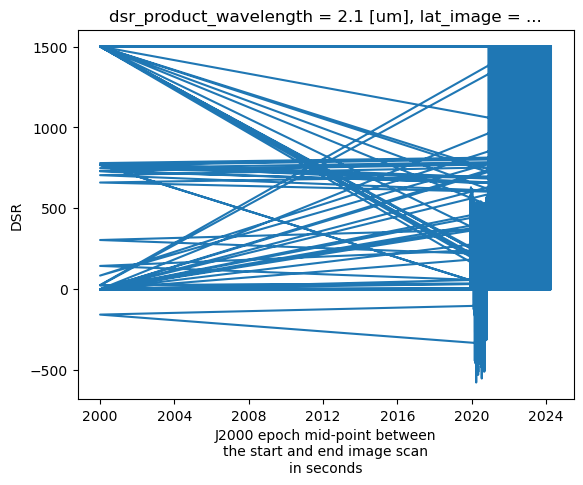

In [5]:
ds.DSR.mean(['lat', 'lon']).plot()

In [6]:
ds_cleaned = ds.drop_duplicates(dim='t').drop_sel(t=np.datetime64('2000-01-01T11:43:21.000000000'))

In [7]:
ds_cleaned

<xarray.Dataset>
Dimensions:                          (t: 37665, lat: 18, lon: 56)
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2019-12-05T16:05:05.2...
Data variables:
    DSR                              (t, lat, lon) float32 dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
    DQF                              (t, lat, lon) float32 dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
Attributes: (12/21)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_ID:             FM1
    iso_series_metadata_id:    de00d810-b013-11e1-afa6-0800200c9a66
    ...                        ...
    project:                   GOES
    scene_id:                  Full Disk
    spatial_resolution:        50km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The Downward Shortwave Radiation: Surface prod...
    title:                     ABI L2 Downward Shortwave Radiation: Surface

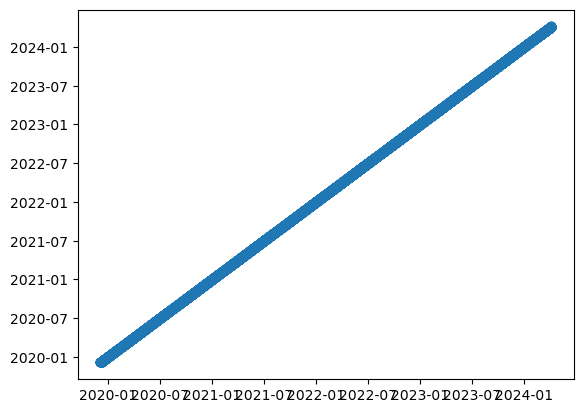

In [8]:
plt.scatter(ds_cleaned.t.values, ds_cleaned.t.values)

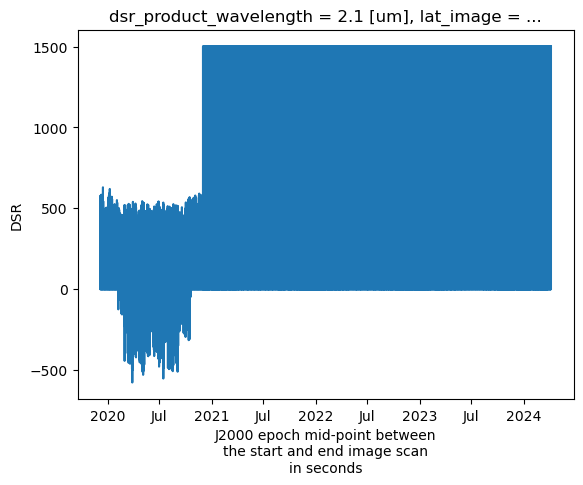

In [9]:
ds_cleaned.DSR.mean(['lat','lon']).plot()

In [10]:
#uploading goes sw ds from 20 - 2012
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sw_ds.zarr')
ds_cleaned.to_zarr(gcsmap_ds, mode='w')

In [95]:
url_list[0]

'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/00/OR_ABI-L2-DSRF-M6_G16_s20230010000206_e20230010009514_c20230010021164.nc'

In [101]:
np.array_equal(file_list, url_list)

False

In [102]:
for a,b in zip(file_list, url_list):
    if a!=b:
        print(a, b)
        break
        

https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/007/11/OR_ABI-L2-DSRF-M6_G16_s20230071110224_e20230071119532_c20230071132124.nc https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/007/12/OR_ABI-L2-DSRF-M6_G16_s20230071200204_e20230071209512_c20230071222382.nc


In [106]:
for a in file_list:
    if a not in url_list:
        print(a)

https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/007/11/OR_ABI-L2-DSRF-M6_G16_s20230071110224_e20230071119532_c20230071132124.nc
https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/035/16/OR_ABI-L2-DSRF-M6_G16_s20230351610204_e20230351619512_c20230351636252.nc
https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/049/16/OR_ABI-L2-DSRF-M6_G16_s20230491610205_e20230491619513_c20230491636176.nc
https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/063/16/OR_ABI-L2-DSRF-M6_G16_s20230631610204_e20230631619512_c20230631637321.nc
https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/091/11/OR_ABI-L2-DSRF-M6_G16_s20230911110224_e20230911119532_c20230911135455.nc
https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/105/11/OR_ABI-L2-DSRF-M6_G16_s20231051110224_e20231051119534_c20231051135568.nc
https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/114/21/OR_ABI-L2

In [103]:
file_list==url_list

False

## Open all files in `2023` dir using gcsfs.GCSFilesystem

In [79]:
#make a list of second to last dir (ending with the day #)
day_dir_list = [("gcp-public-data-goes-16/ABI-L2-DSRF/2023/" + f"{i}/") for i in ["{:03d}".format(i) for i in np.arange(1,366)]]

In [80]:
gcsfs.GCSFileSystem().glob("gcp-public-data-goes-16/ABI-L2-DSRF/2023/*/*")

['gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/00',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/01',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/02',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/03',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/04',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/05',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/06',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/07',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/08',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/09',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/10',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/11',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/12',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/13',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/14',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/15',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/16',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/17',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/18',
 'gcp-public

In [81]:
day_dir_list

['gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/002/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/003/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/004/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/005/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/006/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/007/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/008/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/009/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/010/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/011/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/012/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/013/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/014/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/015/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/016/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/017/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/018/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/019/',
 'gcp-public-data-goes-16/ABI-L2-DSRF/2023/020/',


In [82]:
#flatten file list function
import itertools

def flatten_list(nested_list):
    return list(itertools.chain(*nested_list))

In [83]:
#make a list of all the hourly dirs
hour_list = []

for i in np.arange(365):
    hour_list.append(gcsfs.GCSFileSystem().ls(day_dir_list[i]))

#make a flattened list of all the files (hourly)
flattened_hour_list = flatten_list(hour_list)
file_list = []

for i in np.arange(len(flattened_hour_list)):
    file_list.append(gcsfs.GCSFileSystem().ls(flattened_hour_list[i]))

In [84]:
file_list[0][0]

'gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/00/OR_ABI-L2-DSRF-M6_G16_s20230010000206_e20230010009514_c20230010021164.nc'

In [85]:
#add http protocol to each dir path
url_list = []
for i in np.arange(8728):
    url_list.append("https://storage.googleapis.com/" + file_list[i][0])

In [86]:
url_list[0]

'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/00/OR_ABI-L2-DSRF-M6_G16_s20230010000206_e20230010009514_c20230010021164.nc'

In [14]:
fp_list = list(fsspec.open_files(url_list))

In [15]:
fp_list

[<OpenFile 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/00/OR_ABI-L2-DSRF-M6_G16_s20230010000206_e20230010009514_c20230010021164.nc'>,
 <OpenFile 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/01/OR_ABI-L2-DSRF-M6_G16_s20230010100206_e20230010109514_c20230010120366.nc'>,
 <OpenFile 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/02/OR_ABI-L2-DSRF-M6_G16_s20230010200206_e20230010209514_c20230010219353.nc'>,
 <OpenFile 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/03/OR_ABI-L2-DSRF-M6_G16_s20230010300206_e20230010309514_c20230010318343.nc'>,
 <OpenFile 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/04/OR_ABI-L2-DSRF-M6_G16_s20230010400206_e20230010409514_c20230010417340.nc'>,
 <OpenFile 'https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/05/OR_ABI-L2-DSRF-M6_G16_s20230010500208_e20230010509516_c20230010518006.nc'>

In [16]:
fp_list[0].open()

<File-like object HTTPFileSystem, https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-DSRF/2023/001/00/OR_ABI-L2-DSRF-M6_G16_s20230010000206_e20230010009514_c20230010021164.nc>

In [20]:
ds = xr.open_dataset(fp_list[0].open(), engine='h5netcdf')

In [31]:
ds1 = xr.open_dataset(fp_list[1].open(), engine='h5netcdf')

In [32]:
ds.t.values

numpy.datetime64('2023-01-01T00:05:06.022331904')

In [34]:
ds1.t.values

numpy.datetime64('2023-01-01T01:05:06.021991040')

In [42]:
ds = xr.open_dataset(fp_list[0].open(), engine='h5netcdf') 
for i in np.arange(8728):
    ds_temporary = xr.open_dataset(fp_list[i].open(), engine='h5netcdf')
    ds = xr.concat([ds, ds_temporary], dim='t')

In [101]:
ds

<xarray.Dataset>
Dimensions:                                 (lat: 326, lon: 326,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_wavelength_bounds: 2)
Coordinates:
    t                                       datetime64[ns] 2023-08-15T16:05:0...
  * lat                                     (lat) float64 81.25 80.75 ... -81.25
  * lon                                     (lon) float64 -218.2 ... -55.75
    lat_image                               float32 ...
    lon_image                               float32 ...
    retrieval_local_zenith_angle            float32 ...
    quantitative_local_zenith_angle         float32 ...
    retrieval_solar_zenith_angle            float32 ...
    quantitative_solar_zenith_angle         float32 ...
    dsr_product_wavelength                  float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                number_of_wavelength_bounds
Data variables: (12/32)
    DSR                                     (lat, lon) float32 ...
    DQF                                     (lat, lon) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_lat_lon_projection                 int32 ...
    lat_image_bounds                        (number_of_image_bounds) float32 ...
    lon_image_bounds                        (number_of_image_bounds) float32 ...
    ...                                      ...
    std_dev_dsr                             float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-08-15T16:00:21.9Z
    time_coverage_end:         2023-08-15T16:09:52.7Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        92103fc7-1d41-431c-a12e-636c8a40c3c8

In [68]:
ds_cleaned = ds.isel(t=slice(1, None))

In [121]:
ds_cleaned

<xarray.Dataset>
Dimensions:                                 (t: 8728, lat: 326, lon: 326,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_wavelength_bounds: 2)
Coordinates:
  * t                                       (t) datetime64[ns] 2023-01-01T00:...
  * lat                                     (lat) float64 81.25 80.75 ... -81.25
  * lon                                     (lon) float64 -156.2 -155.8 ... 6.25
    lat_image                               float32 0.0
    lon_image                               float32 -75.0
    retrieval_local_zenith_angle            float32 90.0
    quantitative_local_zenith_angle         float32 70.0
    retrieval_solar_zenith_angle            float32 90.0
    quantitative_solar_zenith_angle         float32 70.0
    dsr_product_wavelength                  float32 2.1
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                number_of_wavelength_bounds
Data variables: (12/32)
    DSR                                     (t, lat, lon) float32 nan ... nan
    DQF                                     (t, lat, lon) float32 1.0 ... 1.0
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] ...
    goes_lat_lon_projection                 (t) int32 -2147483647 ... -214748...
    lat_image_bounds                        (t, number_of_image_bounds) float32 ...
    lon_image_bounds                        (t, number_of_image_bounds) float32 ...
    ...                                      ...
    std_dev_dsr                             (t) float32 161.7 107.1 ... 200.6
    percent_uncorrectable_GRB_errors        (t) float32 0.0 0.0 0.0 ... 0.0 0.0
    percent_uncorrectable_L0_errors         (t) float32 0.0 0.0 0.0 ... 0.0 0.0
    algorithm_dynamic_input_data_container  (t) int32 -2147483647 ... -214748...
    processing_parm_version_container       (t) int32 -2147483647 ... -214748...
    algorithm_product_version_container     (t) int32 -2147483647 ... -214748...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-01-01T00:00:20.6Z
    time_coverage_end:         2023-01-01T00:09:51.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        4ce9f0dd-2f19-49e0-a7e4-040acfdfb3ac

In [122]:
#uploading era sw/sst ds from 2000 - 2012
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/dsr2023.zarr')
ds_cleaned.to_zarr(gcsmap_ds, mode='w')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:2521: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:2521: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]


In [123]:
ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/dsr2023.zarr'))

In [126]:
ds.nbytes/1e9

7.422191708

In [64]:
ds.t[1:]

<xarray.DataArray 't' (t: 8728)>
array(['2023-01-01T00:05:06.022331904', '2023-01-01T01:05:06.021991040',
       '2023-01-01T02:05:06.023614976', ..., '2023-12-31T21:05:05.976829952',
       '2023-12-31T22:05:05.978555008', '2023-12-31T23:05:05.977843968'],
      dtype='datetime64[ns]')
Coordinates:
  * t                                (t) datetime64[ns] 2023-01-01T00:05:06.0...
    lat_image                        float32 0.0
    lon_image                        float32 -75.0
    retrieval_local_zenith_angle     float32 90.0
    quantitative_local_zenith_angle  float32 70.0
    retrieval_solar_zenith_angle     float32 90.0
    quantitative_solar_zenith_angle  float32 70.0
    dsr_product_wavelength           float32 2.1
Attributes:
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time
    axis:           T
    bounds:         time_bounds

In [77]:
import numpy as np

In [79]:
np.unique(ds_cleaned.t.values).shape

(8720,)

In [80]:
# Python program to print duplicates from 
# a list of integers
lis = ds_cleaned.t.values

uniqueList = []
duplicateList = []

for i in lis:
	if i not in uniqueList:
		uniqueList.append(i)
	elif i not in duplicateList:
		duplicateList.append(i)

print(duplicateList)


[numpy.datetime64('2000-01-01T11:43:21.000000000')]


In [120]:
ds_copy.t[['2023-03-04']]

IndexError: arrays used as indices must be of integer or boolean type

In [104]:
ds_copy = ds_cleaned

In [110]:
ds_copy.t.sel(t='2000-01-01T11:43:21.000000000', method='nearest')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [69]:
gulf = ds_cleaned.DSR.sel(lat=slice(31,22), lon=slice(-100,-72))

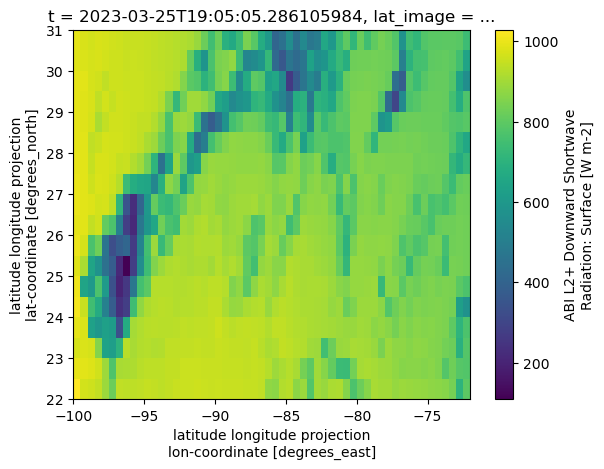

In [70]:
gulf[2010].plot()

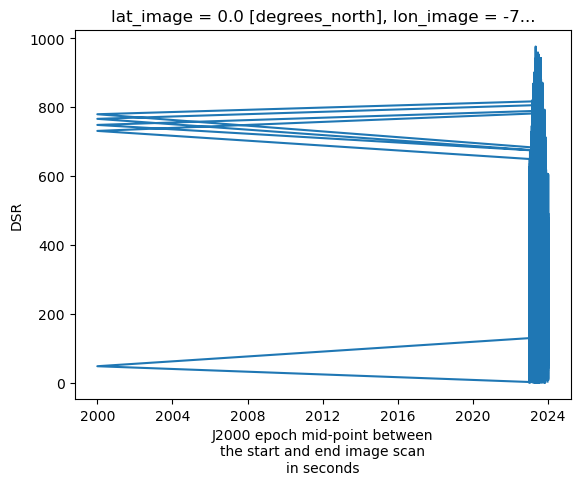

In [71]:
gulf.mean(['lat','lon']).plot()

In [39]:
xr.concat([ds, ds1], dim='t')

<xarray.Dataset>
Dimensions:                                 (t: 2, lat: 326, lon: 326,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_wavelength_bounds: 2)
Coordinates:
  * t                                       (t) datetime64[ns] 2023-01-01T00:...
  * lat                                     (lat) float64 81.25 80.75 ... -81.25
  * lon                                     (lon) float64 -156.2 -155.8 ... 6.25
    lat_image                               float32 0.0
    lon_image                               float32 -75.0
    retrieval_local_zenith_angle            float32 90.0
    quantitative_local_zenith_angle         float32 70.0
    retrieval_solar_zenith_angle            float32 90.0
    quantitative_solar_zenith_angle         float32 70.0
    dsr_product_wavelength                  float32 2.1
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                number_of_wavelength_bounds
Data variables: (12/32)
    DSR                                     (t, lat, lon) float32 nan ... nan
    DQF                                     (t, lat, lon) float32 1.0 ... 1.0
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] ...
    goes_lat_lon_projection                 (t) int32 -2147483647 -2147483647
    lat_image_bounds                        (t, number_of_image_bounds) float32 ...
    lon_image_bounds                        (t, number_of_image_bounds) float32 ...
    ...                                      ...
    std_dev_dsr                             (t) float32 161.7 107.1
    percent_uncorrectable_GRB_errors        (t) float32 0.0 0.0
    percent_uncorrectable_L0_errors         (t) float32 0.0 0.0
    algorithm_dynamic_input_data_container  (t) int32 -2147483647 -2147483647
    processing_parm_version_container       (t) int32 -2147483647 -2147483647
    algorithm_product_version_container     (t) int32 -2147483647 -2147483647
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-01-01T00:00:20.6Z
    time_coverage_end:         2023-01-01T00:09:51.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        4ce9f0dd-2f19-49e0-a7e4-040acfdfb3ac

In [17]:
ds = xr.open_mfdataset([fp_list[i].open() for i in np.arange(8728)], engine='h5netcdf')

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

## [AWS GOES-2-GO package](https://github.com/blaylockbk/goes2go) route

## Open zarr file

In [2]:
import xarray as xr
import fsspec
import gcsfs
import numpy as np
import matplotlib.pyplot as plt
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/dsr2023.zarr'))

In [3]:
ds

<xarray.Dataset>
Dimensions:                                 (t: 8728, lat: 326, lon: 326,
                                             number_of_wavelength_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_time_bounds: 2)
Coordinates:
    dsr_product_wavelength                  float32 ...
  * lat                                     (lat) float64 81.25 80.75 ... -81.25
    lat_image                               float32 ...
  * lon                                     (lon) float64 -156.2 -155.8 ... 6.25
    lon_image                               float32 ...
    quantitative_local_zenith_angle         float32 ...
    quantitative_solar_zenith_angle         float32 ...
    retrieval_local_zenith_angle            float32 ...
    retrieval_solar_zenith_angle            float32 ...
  * t                                       (t) datetime64[ns] 2023-01-01T00:...
Dimensions without coordinates: number_of_wavelength_bounds,
                                number_of_image_bounds, number_of_LZA_bounds,
                                number_of_SZA_bounds, number_of_time_bounds
Data variables: (12/32)
    DQF                                     (t, lat, lon) float32 dask.array<chunksize=(1091, 41, 41), meta=np.ndarray>
    DSR                                     (t, lat, lon) float32 dask.array<chunksize=(1091, 41, 41), meta=np.ndarray>
    algorithm_dynamic_input_data_container  (t) int32 dask.array<chunksize=(8728,), meta=np.ndarray>
    algorithm_product_version_container     (t) int32 dask.array<chunksize=(8728,), meta=np.ndarray>
    dsr_product_wavelength_bounds           (t, number_of_wavelength_bounds) float32 dask.array<chunksize=(8728, 2), meta=np.ndarray>
    geospatial_lat_lon_extent               (t) float32 dask.array<chunksize=(8728,), meta=np.ndarray>
    ...                                      ...
    retrieval_local_zenith_angle_bounds     (t, number_of_LZA_bounds) float32 dask.array<chunksize=(8728, 2), meta=np.ndarray>
    retrieval_pixel_count                   (t) float64 dask.array<chunksize=(8728,), meta=np.ndarray>
    retrieval_solar_zenith_angle_bounds     (t, number_of_SZA_bounds) float32 dask.array<chunksize=(8728, 2), meta=np.ndarray>
    std_dev_dsr                             (t) float32 dask.array<chunksize=(8728,), meta=np.ndarray>
    std_dev_sza                             (t) float32 dask.array<chunksize=(8728,), meta=np.ndarray>
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(8728, 2), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    dataset_name:              OR_ABI-L2-DSRF-M6_G16_s20230010000206_e2023001...
    date_created:              2023-01-01T00:21:16.4Z
    id:                        4ce9f0dd-2f19-49e0-a7e4-040acfdfb3ac
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The Downward Shortwave Radiation: Surface prod...
    time_coverage_end:         2023-01-01T00:09:51.4Z
    time_coverage_start:       2023-01-01T00:00:20.6Z
    timeline_id:               ABI Mode 6
    title:                     ABI L2 Downward Shortwave Radiation: Surface

In [53]:
ds.nbytes/1e9

7.422191708

In [55]:
7.422191708*23*2

341.42081856799996

In [4]:
gulf = ds.DSR.sel(lon=slice(-100,-72), lat=slice(31,22))

In [5]:
gulf

<xarray.DataArray 'DSR' (t: 8728, lat: 18, lon: 56)>
dask.array<getitem, shape=(8728, 18, 56), dtype=float32, chunksize=(1091, 18, 41), chunktype=numpy.ndarray>
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2023-01-01T00:05:06.0...
Attributes:
    ancillary_variables:  DQF
    cell_methods:         retrieval_local_zenith_angle: point (good or degrad...
    grid_mapping:         goes_lat_lon_projection
    long_name:            ABI L2+ Downward Shortwave Radiation: Surface
    resolution:           lon: 0.5 degree lat: 0.5 degree
    standard_name:        surface_downwelling_shortwave_flux_in_air
    units:                W m-2
    valid_range:          [0, 65530]

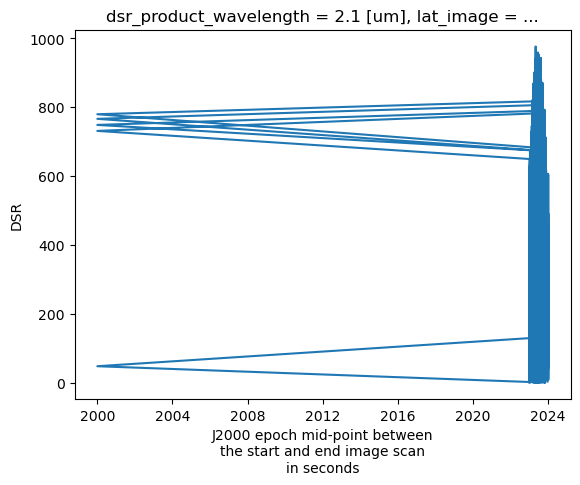

In [6]:
gulf.mean(['lat','lon']).plot()

In [48]:
gulf_c = gulf.drop_duplicates(dim='t').drop_sel(t=np.datetime64('2000-01-01T11:43:21.000000000'))

In [49]:
gulf_c.t

<xarray.DataArray 't' (t: 8719)>
array(['2023-01-01T00:05:06.022331904', '2023-01-01T01:05:06.021991040',
       '2023-01-01T02:05:06.023614976', ..., '2023-12-31T21:05:05.976829952',
       '2023-12-31T22:05:05.978555008', '2023-12-31T23:05:05.977843968'],
      dtype='datetime64[ns]')
Coordinates:
    dsr_product_wavelength           float32 ...
    lat_image                        float32 ...
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2023-01-01T00:05:06.0...
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time

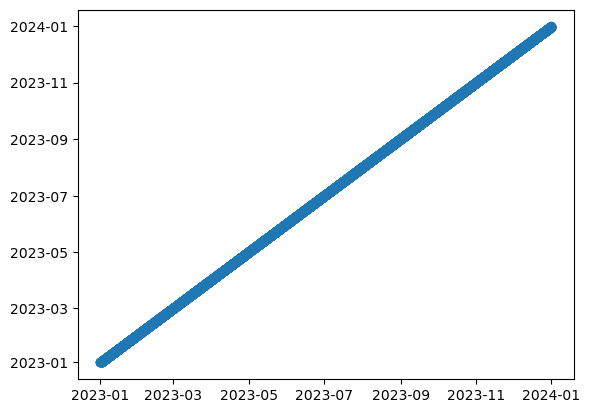

In [51]:
plt.scatter(gulf_c.t.values, gulf_c.t.values)

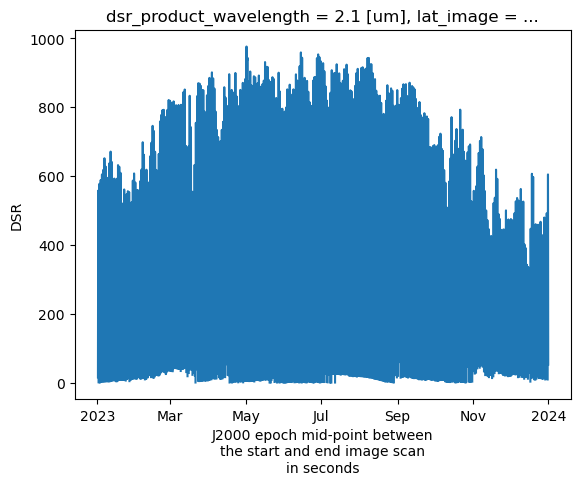

In [52]:
gulf_c.mean(['lat','lon']).plot()

In [20]:
# Python program to print duplicates from 
# a list of integers
lis = gulf_c.t.values

uniqueList = []
duplicateList = []

for i in lis:
	if i not in uniqueList:
		uniqueList.append(i)
	elif i not in duplicateList:
		duplicateList.append(i)

print(duplicateList)


[numpy.datetime64('2000-01-01T11:43:21.000000000')]


In [28]:
[i for i in uniqueList if i==np.datetime64('2000-01-01T11:43:21.000000000')]

[numpy.datetime64('2000-01-01T11:43:21.000000000')]

In [29]:
[i for i in duplicateList if i==np.datetime64('2000-01-01T11:43:21.000000000')]

[numpy.datetime64('2000-01-01T11:43:21.000000000')]

In [24]:
duplicateList=='2000-01-01T11:43:21.000000000'

False

In [21]:
len(uniqueList)

8720

In [32]:
time = gulf.t.where(gulf.t.values != '2000-01-01T11:43:21.000000000')

In [46]:
drop_dup = gulf_c.drop_duplicates(dim='t')
dropped00 = drop_dup.drop_sel(t=np.datetime64('2000-01-01T11:43:21.000000000'))

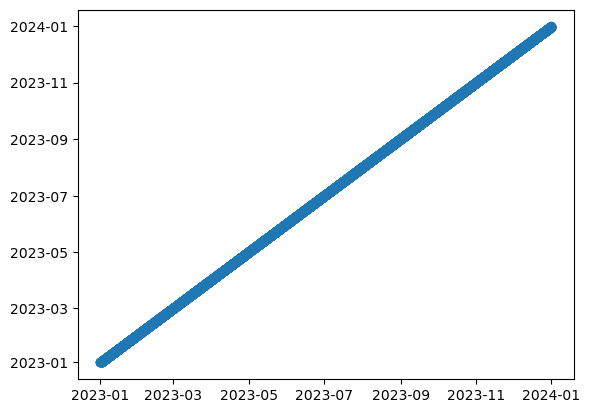

In [47]:
plt.scatter(dropped00.t.values, 
            dropped00.t.values)

In [43]:
drop_dup

<xarray.DataArray 'DSR' (t: 8720, lat: 18, lon: 56)>
dask.array<getitem, shape=(8720, 18, 56), dtype=float32, chunksize=(1091, 18, 41), chunktype=numpy.ndarray>
Coordinates:
    dsr_product_wavelength           float32 ...
  * lat                              (lat) float64 30.75 30.25 ... 22.75 22.25
    lat_image                        float32 ...
  * lon                              (lon) float64 -99.75 -99.25 ... -72.25
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2023-01-01T00:05:06.0...
Attributes:
    ancillary_variables:  DQF
    cell_methods:         retrieval_local_zenith_angle: point (good or degrad...
    grid_mapping:         goes_lat_lon_projection
    long_name:            ABI L2+ Downward Shortwave Radiation: Surface
    resolution:           lon: 0.5 degree lat: 0.5 degree
    standard_name:        surface_downwelling_shortwave_flux_in_air
    units:                W m-2
    valid_range:          [0, 65530]

In [38]:
gulf_c.t.drop_sel({'t':'2000-01-01T11:43:21.000000000'})

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

/tmp/ipykernel_935/3889845463.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.scatter(gulf_c.t.drop(t=np.datetime64('2000-01-01T11:43:21.000000000')).values,
/tmp/ipykernel_935/3889845463.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  gulf_c.t.drop(t=np.datetime64('2000-01-01T11:43:21.000000000')).values)


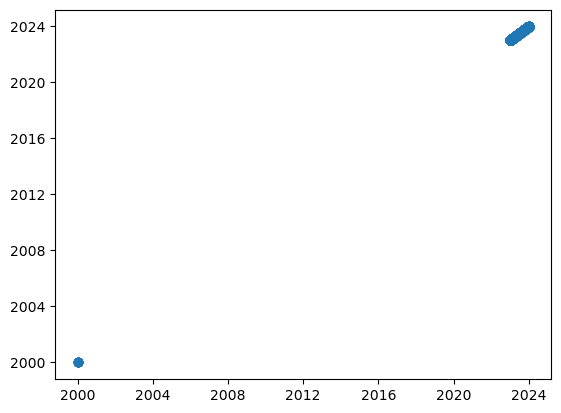

In [33]:
plt.scatter(gulf_c.t.drop(t=np.datetime64('2000-01-01T11:43:21.000000000')).values, 
            gulf_c.t.drop(t=np.datetime64('2000-01-01T11:43:21.000000000')).values)

In [45]:
gulf_c.t.drop_vars(gulf_c.t=='2000-01-01T11:43:21.000000000')

TypeError: unhashable type: 'DataArray'

In [46]:
gulf_dropt = gulf_c.drop_duplicates(dim='t')

In [48]:
gulf_dropt.t

<xarray.DataArray 't' (t: 8720)>
array(['2023-01-01T00:05:06.022331904', '2023-01-01T01:05:06.021991040',
       '2023-01-01T02:05:06.023614976', ..., '2023-12-31T21:05:05.976829952',
       '2023-12-31T22:05:05.978555008', '2023-12-31T23:05:05.977843968'],
      dtype='datetime64[ns]')
Coordinates:
    dsr_product_wavelength           float32 ...
    lat_image                        float32 ...
    lon_image                        float32 ...
    quantitative_local_zenith_angle  float32 ...
    quantitative_solar_zenith_angle  float32 ...
    retrieval_local_zenith_angle     float32 ...
    retrieval_solar_zenith_angle     float32 ...
  * t                                (t) datetime64[ns] 2023-01-01T00:05:06.0...
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time

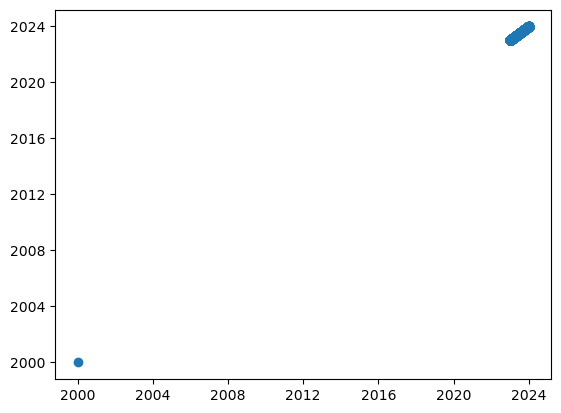

In [47]:
plt.scatter(gulf_dropt.t.values, gulf_dropt.t.values)